In [6]:
import os
os.chdir("/home1/quanquan/code/landmark/code/tproj/")
import cv2
from sklearn.metrics import mutual_info_score
from scipy.stats import entropy
# from scipy.misc import imread
import numpy as np
import cv2
from skimage.exposure import histogram
from scipy.stats import entropy
import matplotlib
from tutils import tfilename
from PIL import Image
import torchvision.transforms.functional as F
from scipy.stats import norm
matplotlib.use('Agg')  # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from einops import rearrange  




EX_CONFIG = {
    'dataset_pth': '/home1/quanquan/datasets/Cephalometric/RawImage/TrainingData',
    # 'dataset_pth': '/home1/quanquan/datasets/Cephalometric/RawImage/NoisyTrainingData10',
    'sift_save_pth': './runs/sift_landmarks3/RawImage/TrainingData',
    'sift_visuals': './runs/sift_landmarks3/RawImage/TrainingData/visuals/',
    'entr': '/home1/quanquan/datasets/Cephalometric/entr1/train/',
    'size': [384, 384],
    'runs_dir': "./runs/",
    'tag': 'sift_landmarks',
}

def get_fea(patch):
    fea = np.zeros((256,))
    hist, idx = histogram(patch, nbins=256)
    for hi, idi in zip(hist, idx):
        # print(hi, idi, i, j)
        fea[idi] = hi
    return fea

def get_fea_by_lm(im, lm):
    ps_half = 32
    patch = im[max(lm[0]-ps_half, 0):lm[0]+ps_half, max(lm[1]-ps_half, 0):lm[1]+ps_half]
    fea1 = get_fea(patch)
    return fea1

def process_one_image(img_id, all_imgs, entr_map):  
    all_landmarks = []
    all_responses = []

    # template
    template = all_imgs[img_id]
    sift = cv2.SIFT_create()
    kp0, des0 = sift.detectAndCompute(template, None)
    landmark_list = []
    response_list = []
    for kpi in kp0:
        response_list.append(kpi.response)
        landmark_list.append(list(kpi.pt))
    response_list = np.array(response_list)
    # print(response_list)
    rank = np.argsort(response_list)[::-1]
    response_list = response_list[rank]
    # print(response_list)
    # lm_list = []
    avg_mi_list = []
    entr_list = []

    for lm_idx in range(20):
        kp_t = np.array(kp0)[rank][lm_idx]
        des_t = des0[rank][lm_idx]
        des_t = rearrange(des_t, "c -> 1 c")
        lm_t = kp_t.pt
        lm_t = np.array(lm_t).round().astype(int)
        fea1 = get_fea_by_lm(template, lm_t)
        entr = entr_map[lm_t[0], lm_t[1]]
        entr_list.append(entr)

        mi_list = []
        # other imgs
        for i, gray in enumerate(all_imgs):
            if i == img_id:
                continue
            sift = cv2.SIFT_create()
            kp, des = sift.detectAndCompute(gray, None)
            BF = cv2.BFMatcher()
            matches = BF.knnMatch(des_t, des, k=2)  # k邻近匹配
            # matches[0].distance
            idx = matches[0][0].trainIdx
            pt_i = kp[idx].pt
            pt_i = np.array(pt_i).round().astype(int)
            # lm_list.append(pt_i)
            fea2 = get_fea_by_lm(gray, pt_i)
            mii = mutual_info_score(fea1, fea2)
            # print(mii)
            mi_list.append(mii)
        mean_mi = np.array(mi_list).mean()
        # print("mean mi ", mean_mi)
        # raise ValueError
        avg_mi_list.append(mean_mi)

    # print("Over!")
    # lm_list = np.array(lm_list).round().astype(int)
    return avg_mi_list, entr_list


def process_all_imgs():
    img_pths = [x.path for x in os.scandir(EX_CONFIG['dataset_pth']) if x.name.endswith('.bmp')]
    img_pths.sort()
    assert len(img_pths) > 0

    imgs = []
    for p in img_pths:        
        img = cv2.imread(p)
        img = cv2.resize(img, tuple(EX_CONFIG['size']))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        imgs.append(gray)
    
    for i, img in enumerate(imgs):
        entr = np.load(EX_CONFIG['entr'] + f"/{i+1}.npy")
        avg_mi_list, entr_list = process_one_image(i, imgs, entr)
        print(avg_mi_list, entr_list)
        break

    return avg_mi_list, entr_list

In [7]:

avg_mi_list, entr_list = process_all_imgs()

0.421742559462775
0.6330481383513038
0.5461779547166244
0.9659248379238266
0.7639859237642475
0.5842180551274639
0.9603449187521729
0.9479345817246565
1.0063855289982233
1.1900518608484514
1.1335997215315665
1.0134550665365452
0.4073598789029393
0.8623123067473343
1.0783712464193196
0.24173920481920036
0.7612811091089221
0.9888932845587062
1.0949020554967217
1.0877469700727456
0.9646889444200859
1.4167564477349661
1.3438424276180534
1.0212930625291436
0.8757237521843111
1.0152526604473229
1.0059163197579544
1.2580288246381874
0.9842216588306081
1.069278994527353
0.3665621086094584
0.9096558669625782
0.4857565028664355
1.001838466997854
0.3010867004911873
0.9588321987282182
1.0142843793820955
0.7769058138350579
0.797190619073417
1.3432117628334665
1.1299739921289604
1.173736032091021
0.9527773066825904
1.0791436462910644
0.876695888728914
1.1318153943118363
0.8902878864345092
1.1738751127547373
0.4373934100537175
0.9290314501437918
0.3991507133367779
0.25237169268748194
0.55488269069552

ValueError: 

In [ ]:
1.119625605631008
0.8567132168950005
0.35553643410656965
1.2294472760574962
0.7873633971051383
0.7700628591066798
0.9582602430487274
1.0522585275643148
0.5109123766920417
0.5480887424418756
0.9893070439441742
1.1589114653055517


0.421742559462775
0.6330481383513038
0.5461779547166244
0.9659248379238266
0.7639859237642475
0.5842180551274639
0.9603449187521729
0.9479345817246565
1.0063855289982233
1.1900518608484514
1.1335997215315665
1.0134550665365452

In [45]:
avg_mi_list = np.array(avg_mi_list)
entr_list = np.array(entr_list)
avg_mi_list[np.where(entr_list>4.5)].mean(),   avg_mi_list[np.where(entr_list>4.5)].std() #, avg_mi_list[np.where(entr_list<2.3)].mean(), avg_mi_list[np.where(entr_list<2.3)].std()

(1.3761376741017535, 0.22129679161513377)

In [44]:
ll = []
for i, entr in enumerate(entr_list):
    if entr < 4.5 and entr > 2.3:
        ll.append(avg_mi_list[i])
        # print(avg_mi_list[i])
np.array(ll).mean(), np.array(ll).std()

(1.2074211138549695, 0.1978275839846204)

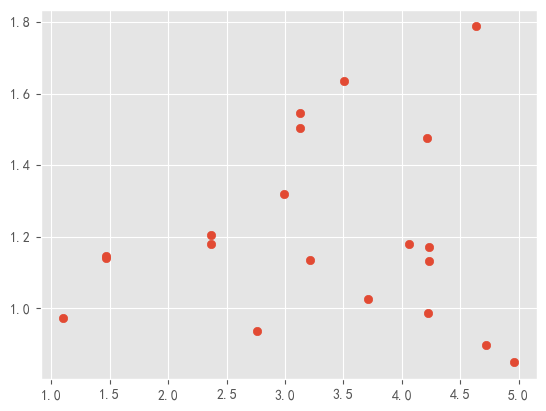

In [33]:
%matplotlib inline
import matplotlib.pylab as plt
plt.scatter(entr_list, avg_mi_list)